In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_90-10.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_85-15.csv.gz', compression='gzip', index_col='ztf_object_id')
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20.csv.gz', compression='gzip', index_col='ztf_object_id')

dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19ackimld,0.193100,-0.307408,0.400000,0.000000,0.253017,0.386200,0.355100,0.147900,-0.405911,0.000503,...,0.035700,-0.110800,-0.124800,-0.172100,75.583421,2.088205,No_TNS,None,-99.0,None
ZTF20acoxdas,0.627042,-0.186492,0.333333,0.000000,0.408828,1.254084,1.060876,0.757065,-0.677916,0.018984,...,0.568499,0.698500,0.668100,0.216900,12.467979,0.943354,Yes_TNS,SN Ia,0.1,ALeRCE
ZTF20acibvgy,0.182631,-0.574715,0.200000,0.000000,0.394121,0.365263,0.365263,0.219012,0.326944,0.017688,...,0.660299,0.908699,0.736700,0.528099,71.406949,0.326222,Yes_TNS,None,-99.0,ALeRCE
ZTF20acbrlih,0.386832,-0.256474,0.461538,0.000000,0.402720,0.773664,0.765432,0.572464,-1.158863,-0.001732,...,0.724899,0.823900,0.538300,0.744900,55.308887,0.434827,Yes_TNS,None,-99.0,Pan-STARRS
ZTF19aadfqfw,0.868800,-0.199488,0.333333,0.000000,0.422124,1.737600,1.714910,1.510700,-1.395242,-0.103710,...,1.252501,1.324600,1.435499,1.297100,1.605507,0.394891,Yes_TNS,None,-99.0,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,0.070928,-0.351747,0.200000,0.000000,0.305973,0.141855,0.141855,0.092972,-0.246354,0.005672,...,0.960799,0.944100,1.015100,1.232200,69.743472,0.422087,Yes_TNS,None,-99.0,ALeRCE
ZTF21aapkuur,0.106760,-0.744001,0.400000,0.000000,0.378529,0.213520,0.213520,0.128711,-0.074463,0.010770,...,0.028999,0.152800,0.133600,0.009901,46.527568,0.063019,Yes_TNS,SN Ia,0.1,Pan-STARRS
ZTF21aaxhveb,0.528692,-0.107271,0.300000,0.000000,0.425558,1.057384,0.937274,0.773542,-1.095850,0.025321,...,0.525501,0.609900,0.615601,0.650200,19.159718,1.140695,Yes_TNS,None,-99.0,ALeRCE


### Both noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20 and noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20 are good (hostdownweighted maybe sliiightly better)

### suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # Best one????


In [3]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_90-10" # could be ok
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_90-10" # not great
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_90-10" # decent
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # eh


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_90-10" # decent but hard to say
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_85-15" # decent; better than 90-10
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #good

#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_90-10" # eh
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_85-15" # better than hostdownweighted 85-15
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # good. slightly worse than hostdownweighted_SMOTE_80-20


suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # Best one????



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_90-10"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_85-15" # tied second best
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_80-20" # tied second best


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aadqidc,199.451404,213.534149
ZTF18aadlaxo,209.592521,226.815674
ZTF18aahsuyl,183.071466,192.821228
ZTF18aaisqmw,279.769908,285.162231
ZTF18aajgowk,231.230307,247.530502
...,...,...
ZTF21aciuhqw,265.662956,287.737152
ZTF21acjgpvq,231.745461,251.912277
ZTF21acjjyvv,207.396844,218.451447


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aadqidc,199.451404,213.534149,0.118791,-0.558108,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000000,None
ZTF18aadlaxo,209.592521,226.815674,0.400349,-0.333744,0.111111,0.333333,0.379893,0.800697,0.648489,0.327314,...,0.774100,0.759600,0.756000,0.753699,62.022695,0.036486,Yes_TNS,SN Ia,0.052953,ZTF
ZTF18aahsuyl,183.071466,192.821228,0.456472,-0.436415,0.227273,0.000000,0.407459,0.912945,0.746155,0.433327,...,0.466700,0.441700,0.474998,0.291601,38.796355,0.199907,Yes_TNS,None,-99.000000,ALeRCE
ZTF18aaisqmw,279.769908,285.162231,0.526477,-0.165949,0.400000,0.000000,0.297334,1.052954,0.822551,0.523870,...,0.728600,0.708699,1.092200,0.573000,627.387102,0.209814,Yes_TNS,SN Ia,0.052700,ZTF
ZTF18aajgowk,231.230307,247.530502,0.276666,-0.502600,0.285714,0.000000,0.314073,0.553331,0.481705,0.174625,...,0.287199,0.198200,0.390800,0.351900,33.862239,0.133331,No_TNS,None,-99.000000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aciuhqw,265.662956,287.737152,0.670816,0.405011,0.150000,0.223607,0.349629,1.341633,0.783248,0.277588,...,0.897000,0.937399,0.836400,0.902900,67.693626,1.141200,Yes_TNS,SN Ic-BL,0.045000,ZTF
ZTF21acjgpvq,231.745461,251.912277,0.158735,-0.929649,0.250000,0.000000,0.304177,0.317471,0.317471,0.241176,...,0.392099,0.417099,0.431299,0.321301,11.002277,0.368490,Yes_TNS,None,-99.000000,ALeRCE
ZTF21acjjyvv,207.396844,218.451447,0.213072,-0.259193,0.375000,0.000000,0.430375,0.426144,0.397676,0.281398,...,0.791101,0.798100,0.678598,0.705400,37.204278,1.176775,Yes_TNS,None,-99.000000,Pan-STARRS


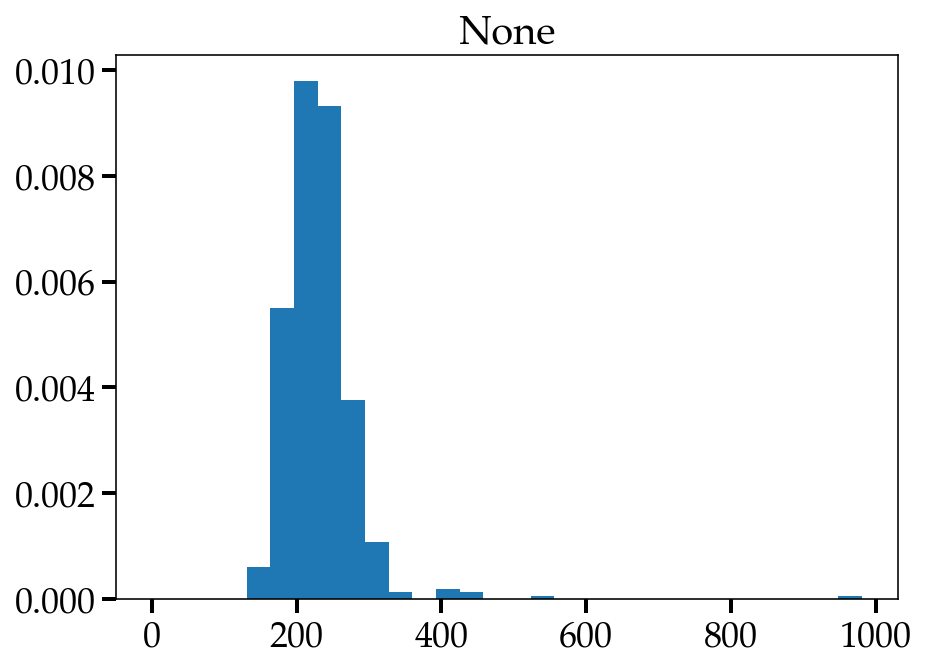

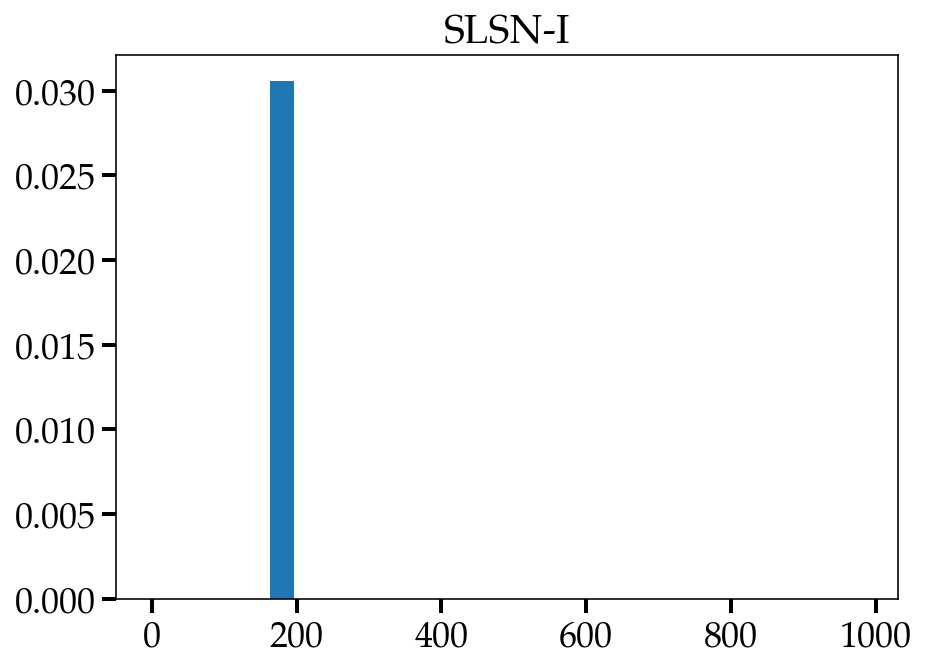

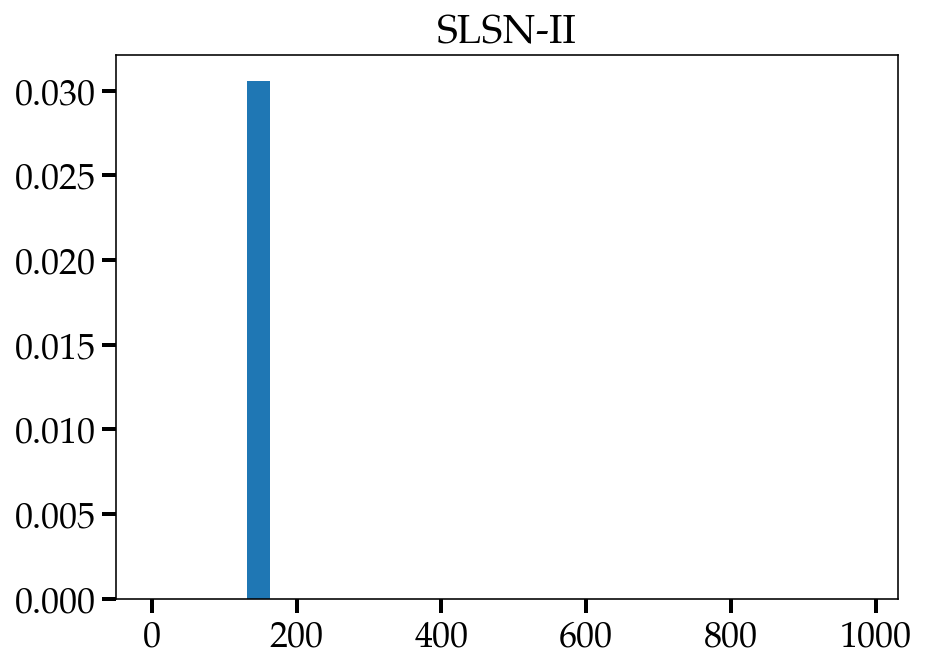

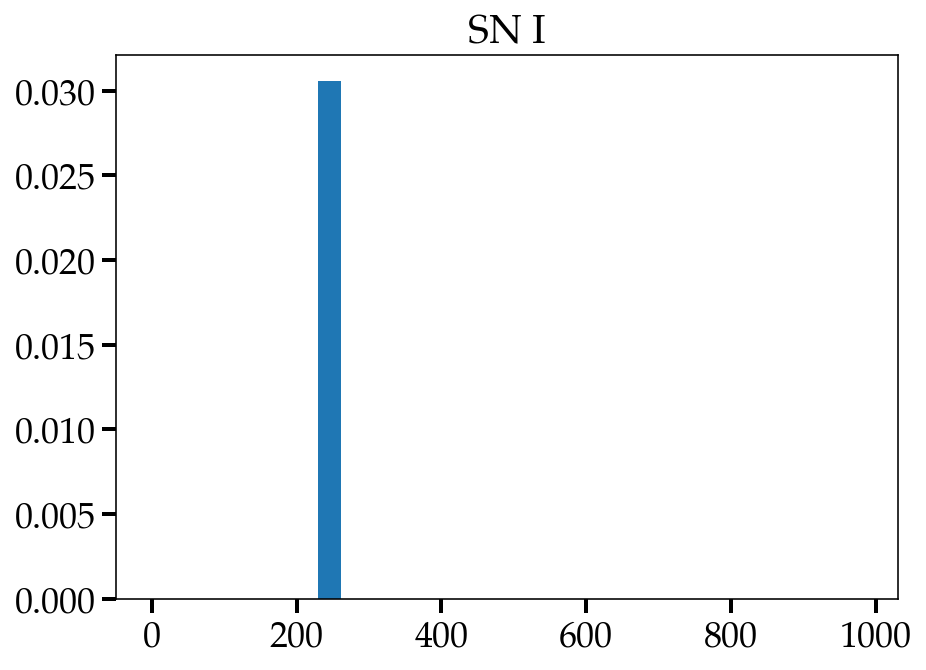

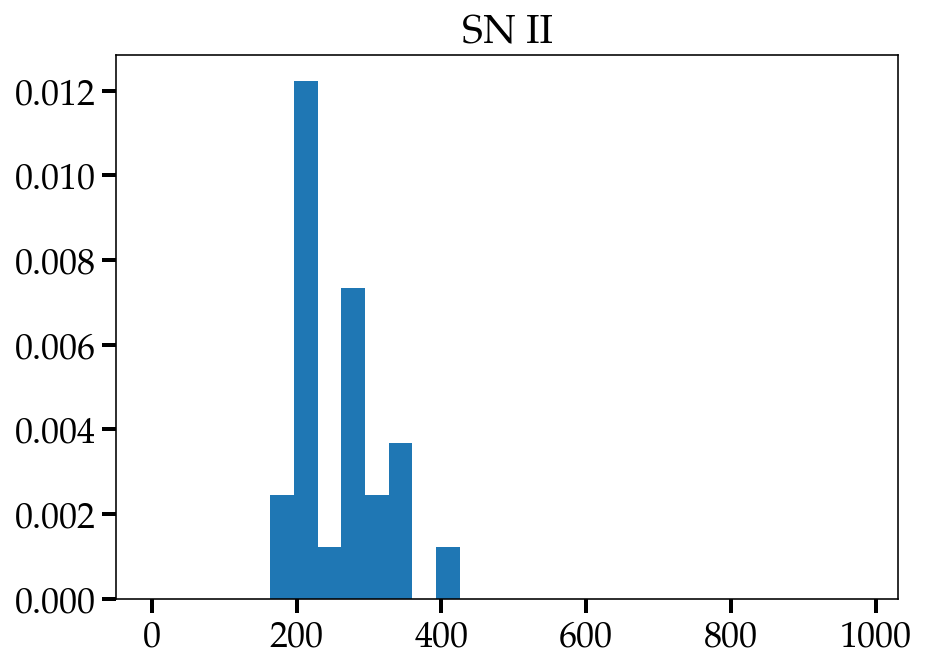

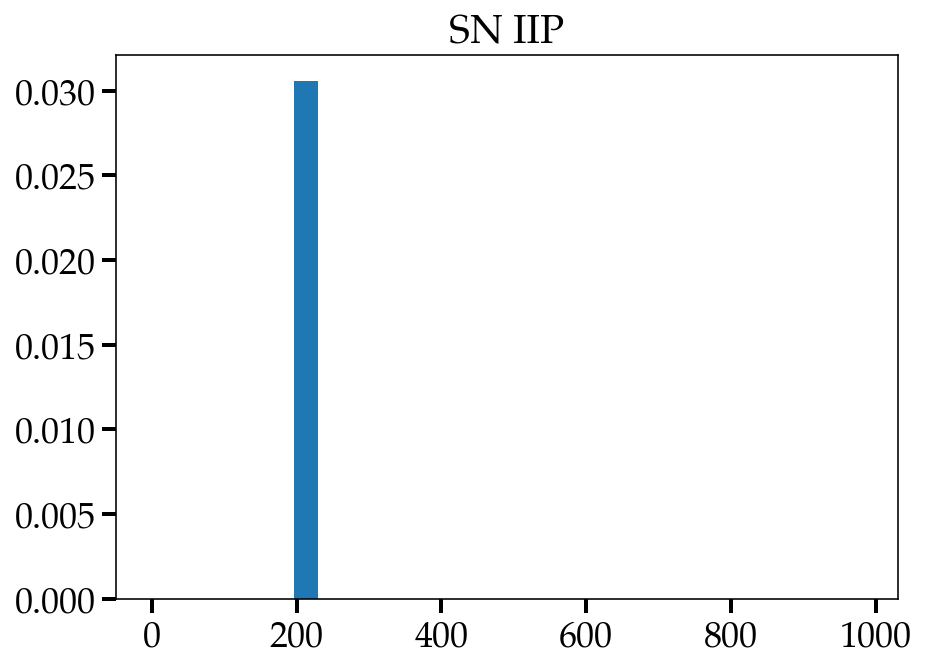

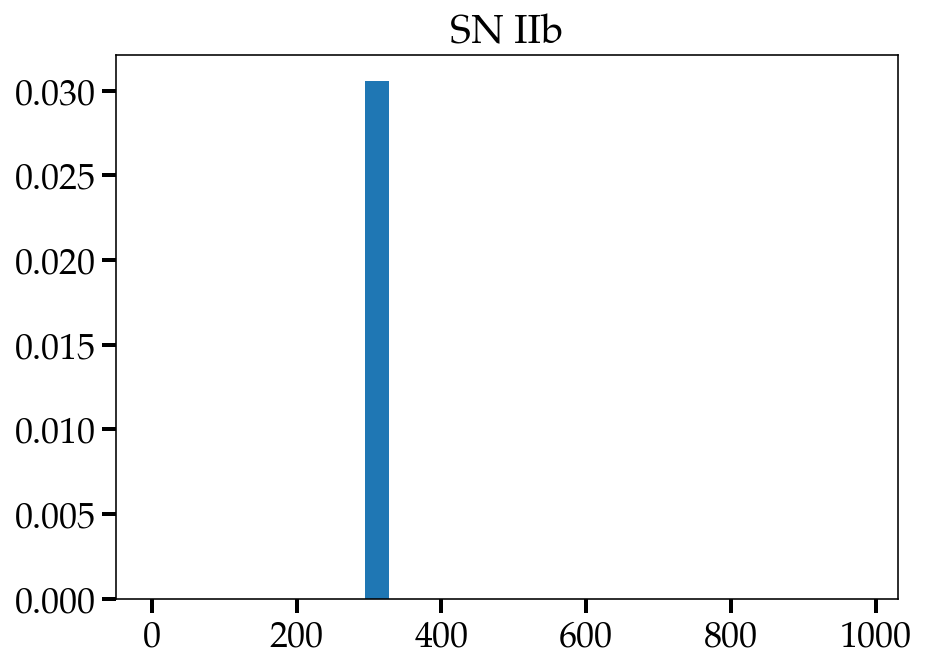

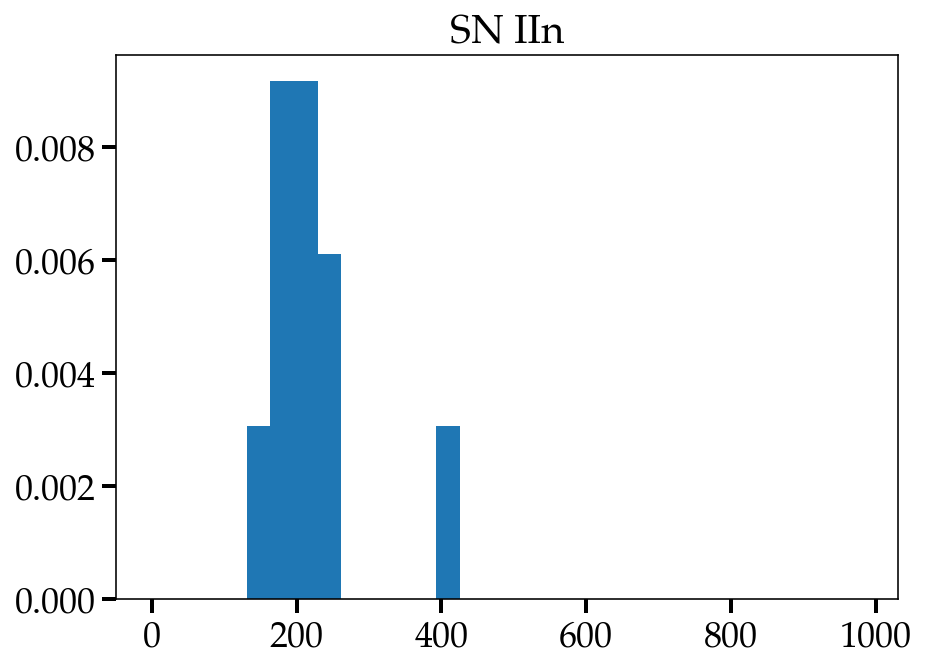

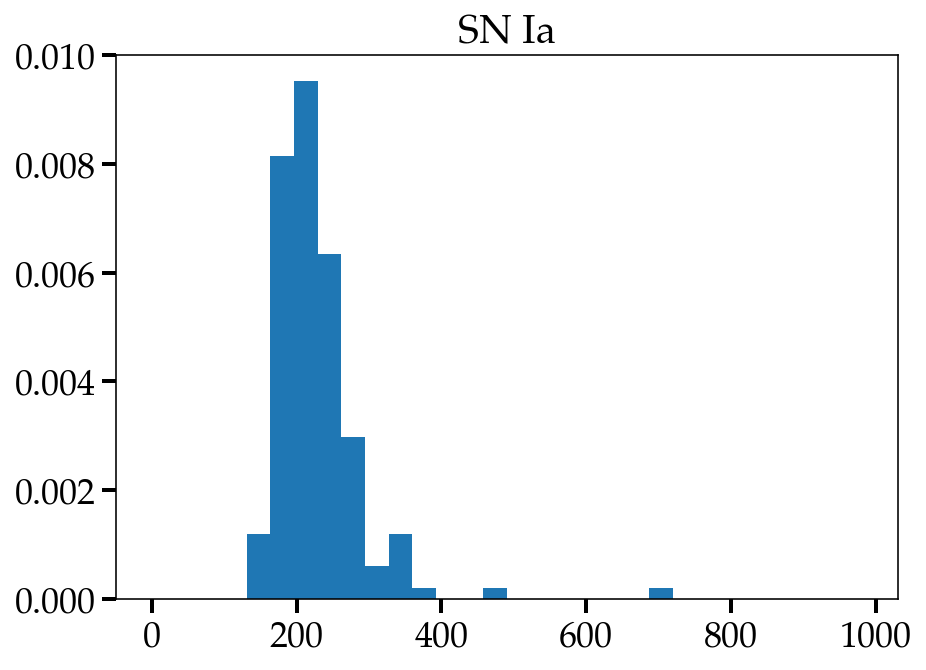

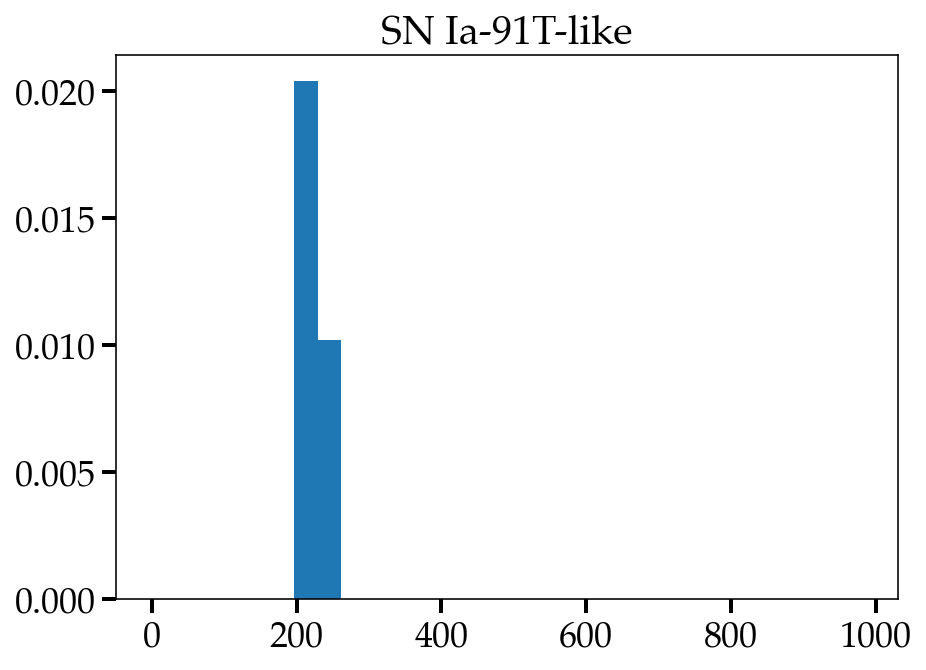

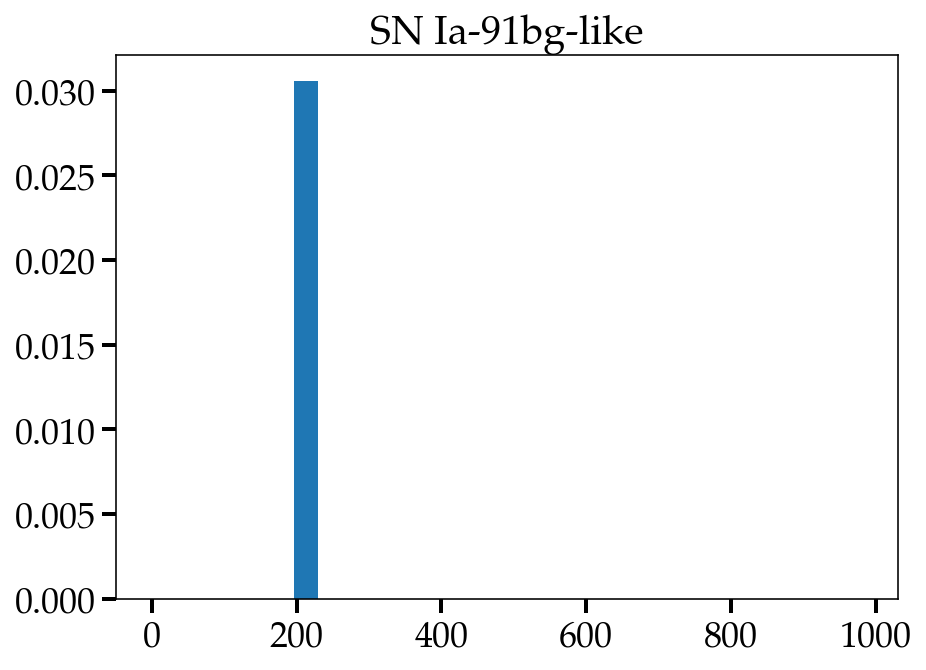

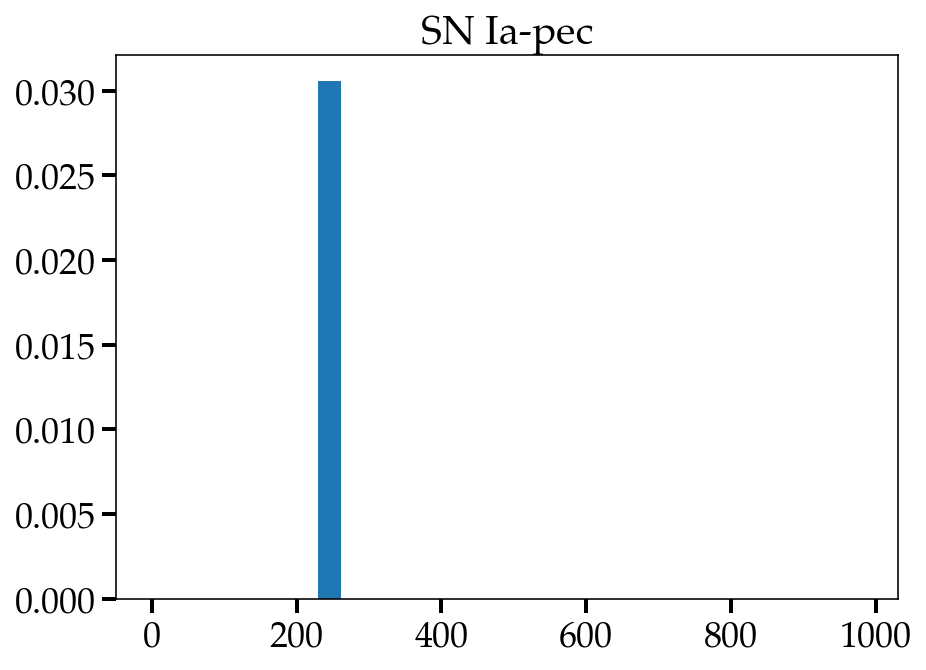

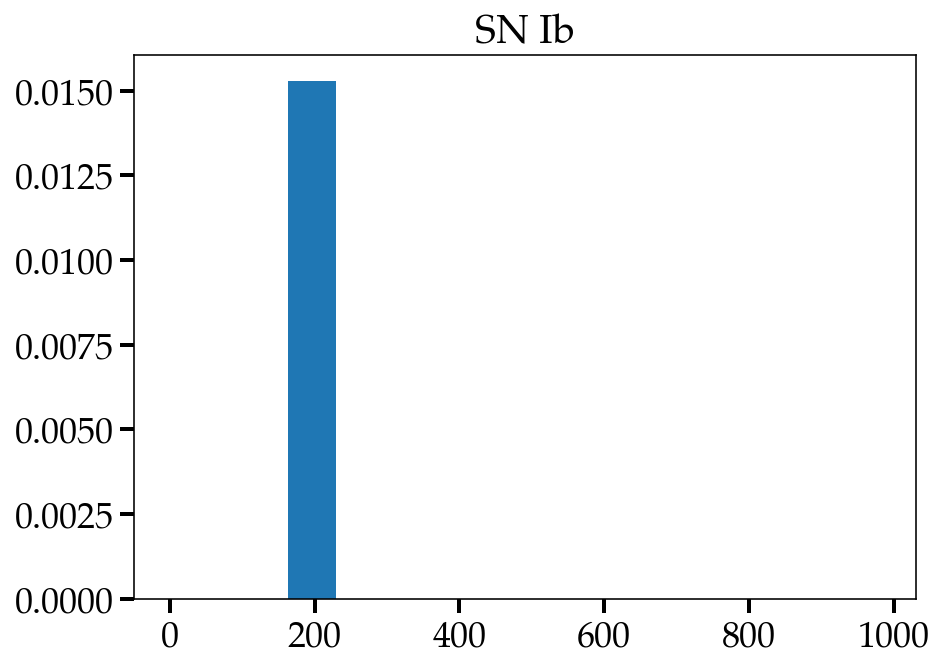

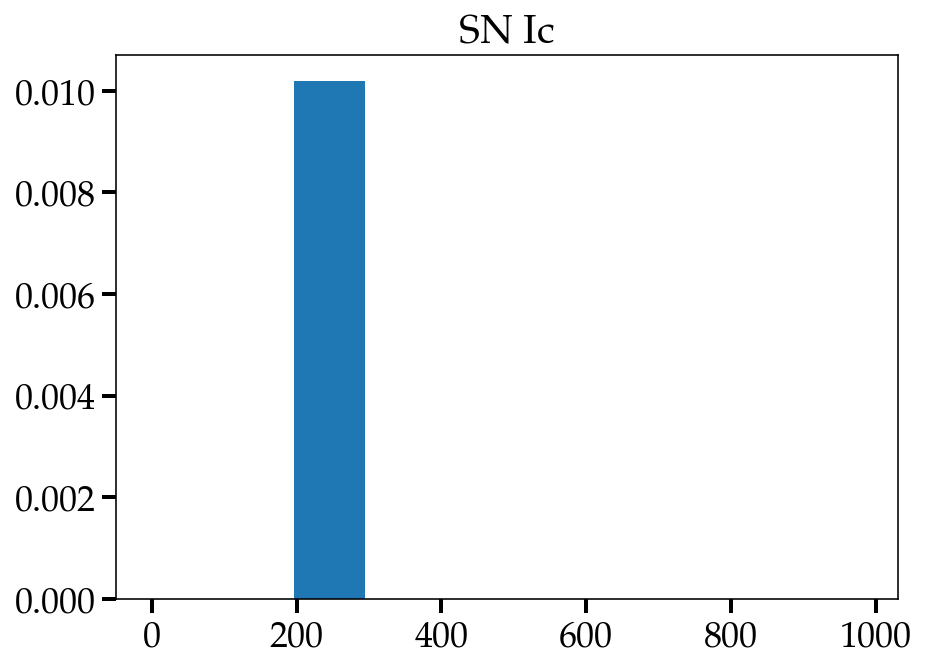

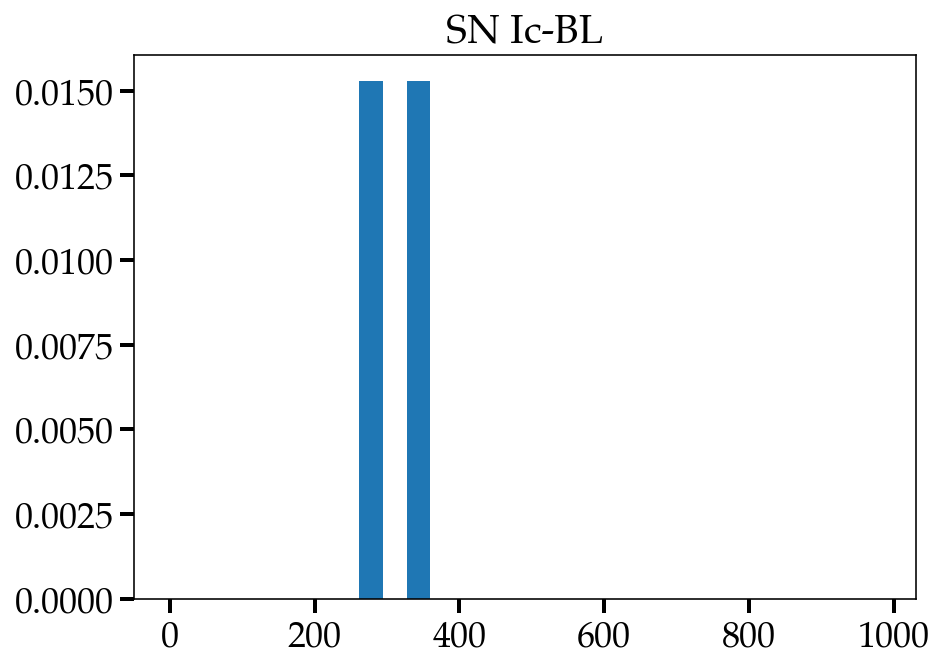

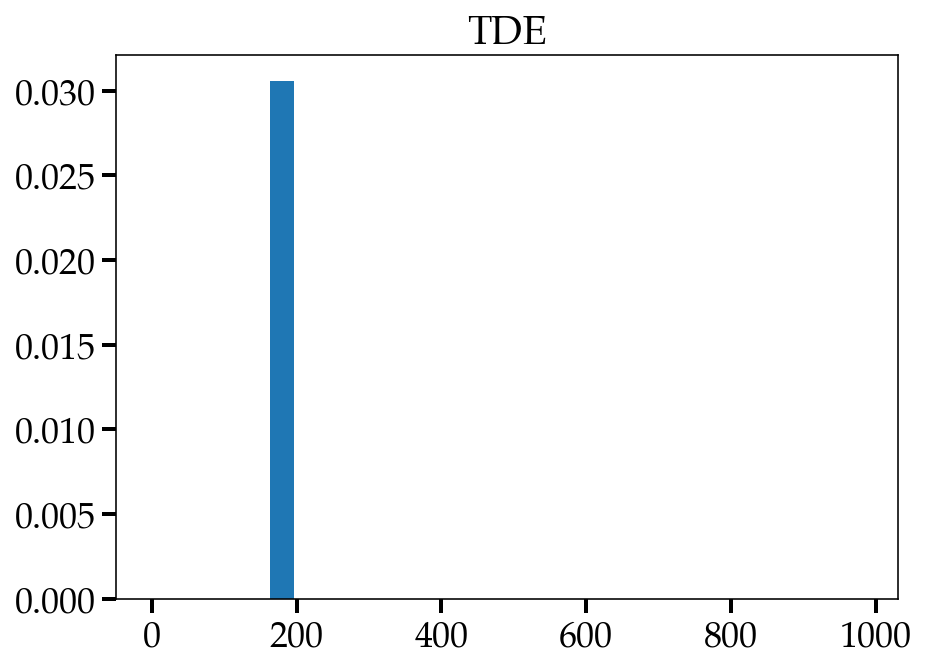

In [5]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


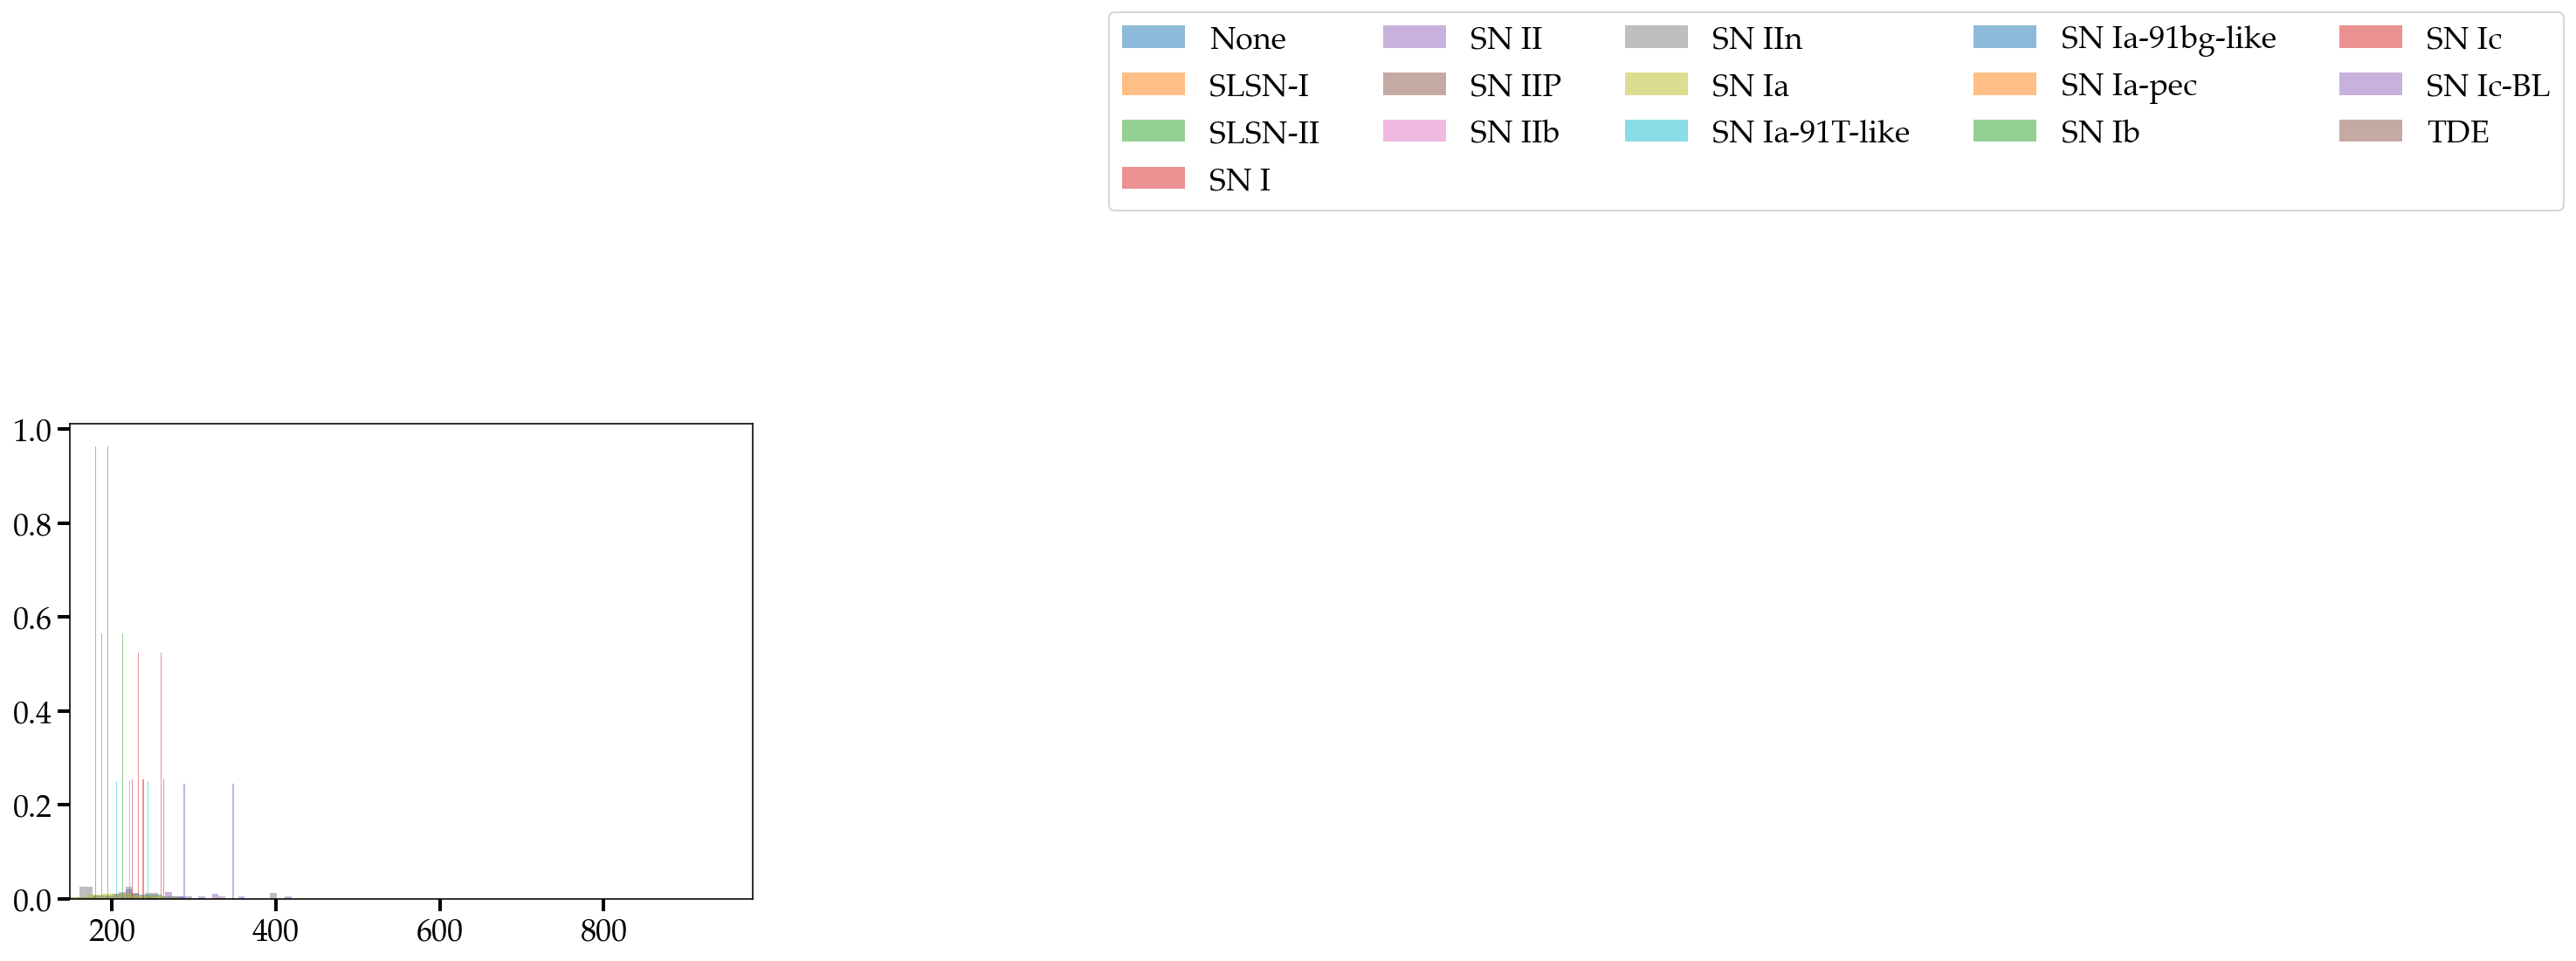

In [6]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

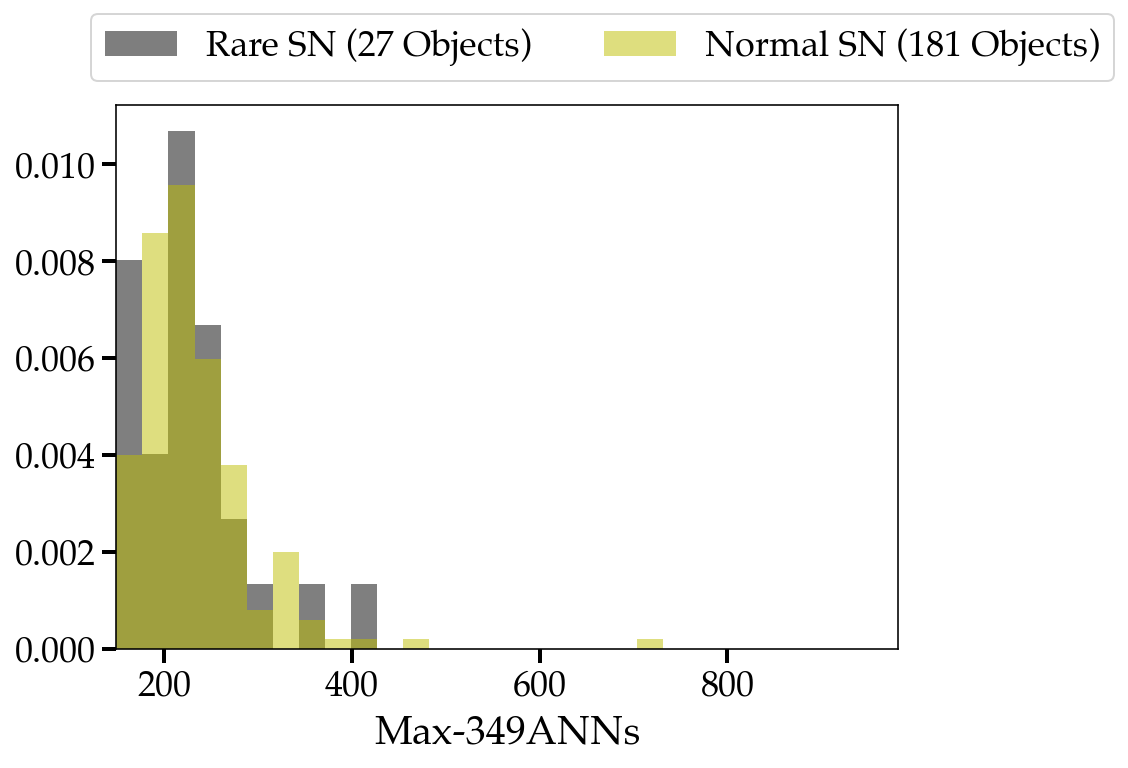

In [7]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [8]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.18518518518518517
P-value: 0.7594199616197995
The two distributions are likely the same.


In [9]:
np.median(normal_sn_df[dist_col])

221.5135498046875

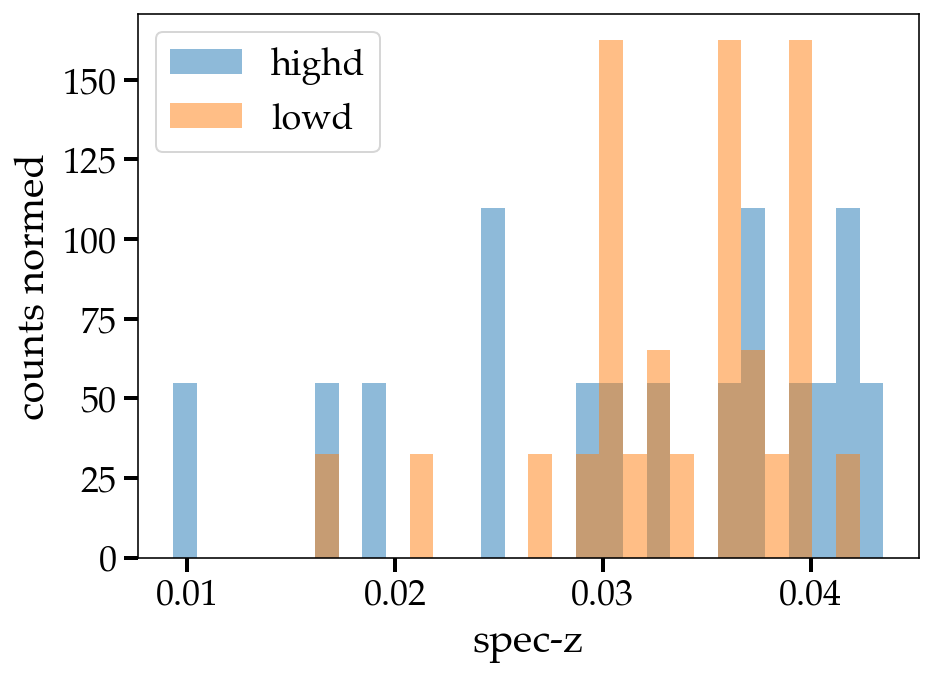

In [10]:
normal_sn_df = normal_sn_df[normal_sn_df.spec_z >= 0]

normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= np.median(normal_sn_df[dist_col])+100]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= np.median(normal_sn_df[dist_col])+100]

bins=np.linspace(np.min(normal_sn_highd_df.spec_z), np.max(normal_sn_highd_df.spec_z), 31)
plt.hist(normal_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [11]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.875
P-value: 0.00021946680376646457
The two distributions are likely different.


In [12]:
np.median(rare_sn_df[dist_col])

221.1062774658203

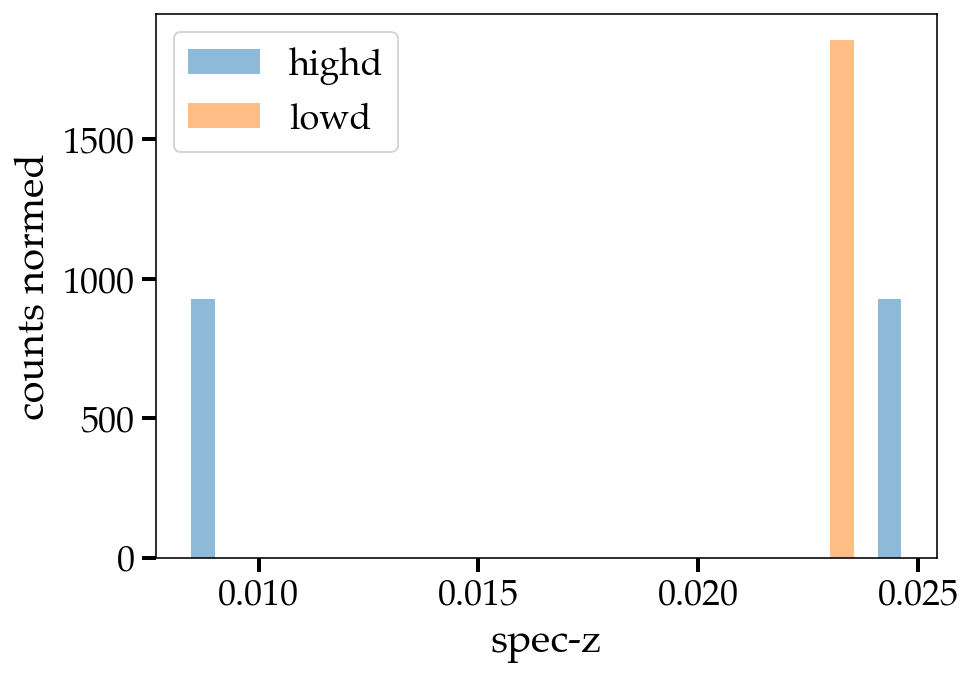

In [13]:
rare_sn_df = rare_sn_df[rare_sn_df.spec_z >= 0]

rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= np.median(rare_sn_df[dist_col])+100]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= np.median(rare_sn_df[dist_col])+100]

bins=np.linspace(np.min(rare_sn_highd_df.spec_z), np.max(rare_sn_highd_df.spec_z), 31)
plt.hist(rare_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [14]:
len(rare_sn_lowd_df)

25

In [15]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.5
P-value: 0.39066666666666655
The two distributions are likely the same.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

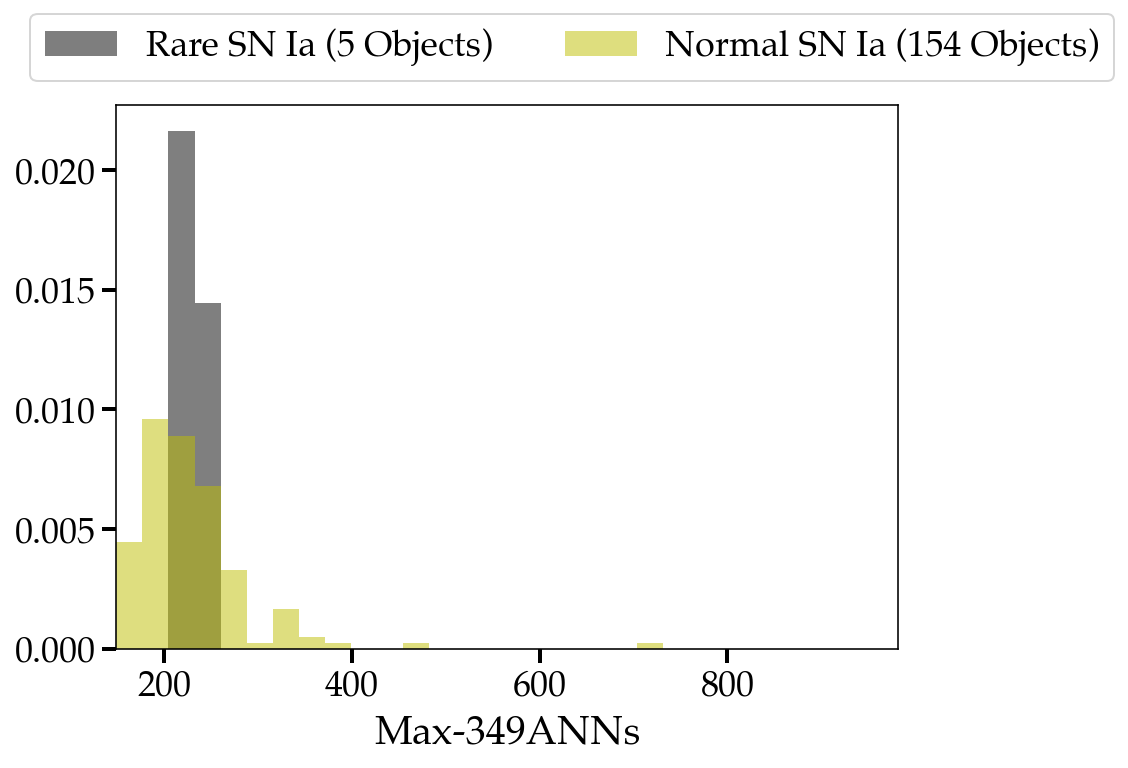

In [16]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [17]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.4
P-value: 0.642063492063492
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [18]:
np.median(normal_snIa_df[dist_col])

220.16242218017578

In [19]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= np.median(normal_snIa_df[dist_col])+100]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= np.median(normal_snIa_df[dist_col])+100]

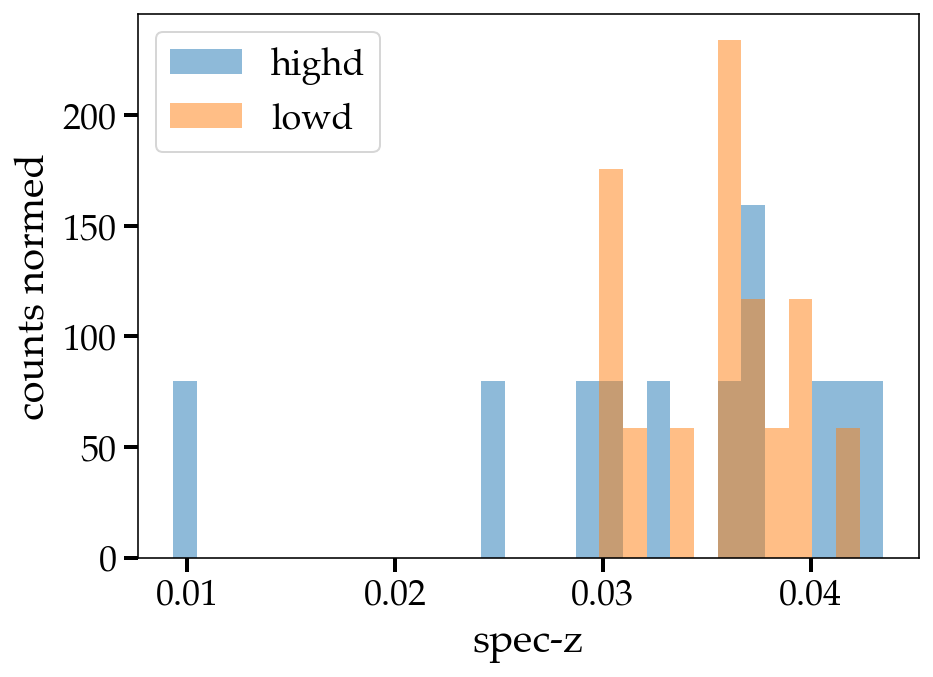

In [20]:
normal_snIa_highd_df = normal_snIa_highd_df[normal_snIa_highd_df.spec_z >= 0]

bins=np.linspace(np.min(normal_snIa_highd_df.spec_z), np.max(normal_snIa_highd_df.spec_z), 31)
plt.hist(normal_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [21]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.9090909090909091
P-value: 0.0010923689313782192
The two distributions are likely different.


In [22]:
np.median(rare_snIa_df[dist_col])

221.1062774658203

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


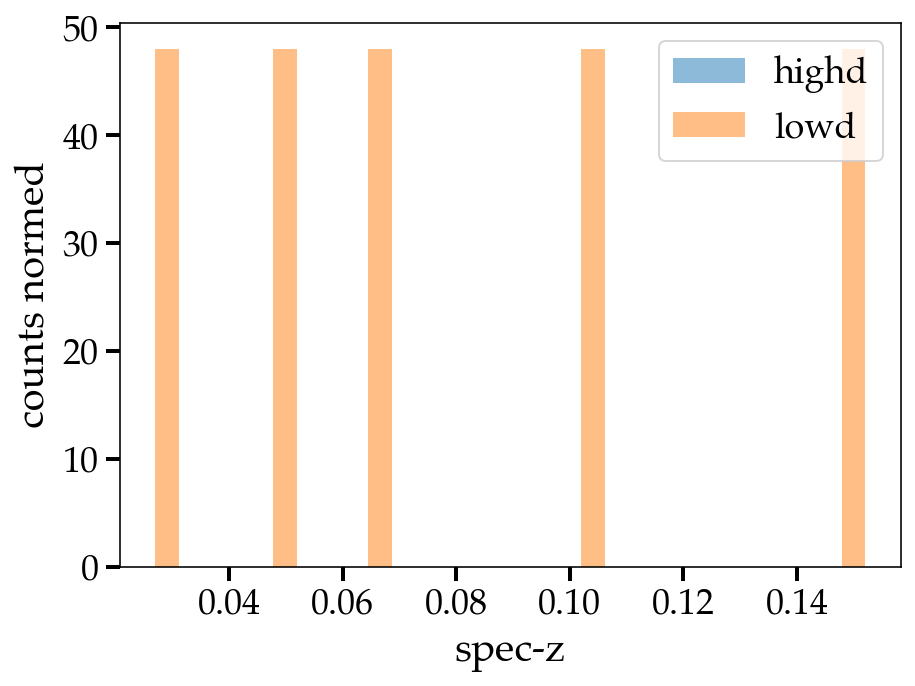

In [23]:
rare_snIa_df = rare_snIa_df[rare_snIa_df.spec_z>=0]

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= np.median(rare_snIa_df[dist_col])+100]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= np.median(rare_snIa_df[dist_col])+100]

bins=np.linspace(np.min(rare_snIa_df.spec_z), np.max(rare_snIa_df.spec_z), 31)

plt.hist(rare_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [24]:
len(rare_snIa_highd_df)

0

In [25]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

ValueError: Data passed to ks_2samp must not be empty

# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [26]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,ann=10_spec_z
ZTF21abdauiq,ZTF21abdauiq,ZTF21abwtyle,ZTF21aaxtufg,ZTF18abuahio,ZTF21aarpmsh,ZTF21acimaio,ZTF21aardvtr,ZTF21abmdfub,ZTF19aarzfoz,ZTF21aaxvvqq,...,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21aaplfah,ZTF21aaplfah,ZTFabc37843,ZTFabc79036,ZTFabc68736,ZTF18aahfbqp,ZTFabc37095,ZTFabc29487,ZTFabc79846,ZTF20acukxat,ZTF21abmjivk,...,-99.000,-99.0,-99.0,0.041362,-99.000000,-99.0,-99.00,0.042546,0.02566,0.035428
ZTF21aapomdb,ZTF21aapomdb,ZTFabc51627,ZTFabc87488,ZTFabc97170,ZTF21aaqgrrf,ZTFabc65374,ZTFabc39565,ZTF20achtxbi,ZTFabc99767,ZTFabc08967,...,-99.000,-99.0,-99.0,0.082000,-99.000000,-99.0,0.07,-99.000000,-99.00000,0.104000
ZTF20acpayvy,ZTF20acpayvy,ZTFabc04712,ZTF21aaxsxui,ZTF18abuioue,ZTFabc59815,ZTFabc71581,ZTFabc53404,ZTFabc30724,ZTFabc73924,ZTFabc27342,...,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF20acnvmbp,ZTF20acnvmbp,ZTFabc42399,ZTFabc62612,ZTFabc56736,ZTFabc83312,ZTFabc30711,ZTFabc22350,ZTFabc86654,ZTFabc49309,ZTFabc52986,...,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,ZTF21aaxsowb,ZTF21abcptwm,ZTF21aaphzlq,ZTF21aalepvi,ZTF21aatxpur,ZTF18adbcjin,ZTF21aagocxm,ZTF20acttirv,ZTF21abxnrfx,ZTF21aamayom,...,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21aapkuur,ZTF21aapkuur,ZTF21aaydomp,ZTF18abnzney,ZTF21aamssts,ZTF20acpyndh,ZTF20aciuftf,ZTF19aarzfoz,ZTF21aarteuc,ZTF18acrxvsn,ZTF20adaeagd,...,-99.000,-99.0,-99.0,-99.000000,0.130000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21aaxhveb,ZTF21aaxhveb,ZTF20acplqek,ZTFabc26919,ZTF21aaqyemz,ZTFabc49230,ZTFabc95434,ZTFabc33691,ZTFabc47866,ZTF21aaqvtcn,ZTF21aagskpt,...,0.083,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21abcmmdl,ZTF21abcmmdl,ZTFabc58018,ZTFabc04948,ZTFabc28672,ZTFabc10879,ZTF21aakigqr,ZTFabc14279,ZTFabc73353,ZTF18adacosi,ZTFabc73438,...,-99.000,-99.0,-99.0,-99.000000,0.066866,-99.0,-99.00,-99.000000,-99.00000,-99.000000


In [27]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 33:44]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls
ZTF21abdauiq,None,None,None,None,None,None,None,None,None,None,None
ZTF21aaplfah,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
ZTF21aapomdb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
ZTF20acpayvy,None,SN Ia,None,None,SN Ia,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF20acnvmbp,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,None,None,None,None,None,None,None,None,None,None,None
ZTF21aapkuur,SN Ia,None,None,None,None,SN Ia,None,None,None,None,None
ZTF21aaxhveb,None,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,None,None,None
ZTF21abcmmdl,None,SN II,SN II,SN II,SN II,SN II,SN II,SN II,None,SN II,SN II


In [28]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 44:55]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,ann=10_spec_z
ZTF21abdauiq,-99.0000,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21aaplfah,0.0358,-99.000,-99.0,-99.0,0.041362,-99.000000,-99.0,-99.00,0.042546,0.02566,0.035428
ZTF21aapomdb,0.0700,-99.000,-99.0,-99.0,0.082000,-99.000000,-99.0,0.07,-99.000000,-99.00000,0.104000
ZTF20acpayvy,-99.0000,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF20acnvmbp,-99.0000,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,-99.0000,-99.000,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21aapkuur,0.1000,-99.000,-99.0,-99.0,-99.000000,0.130000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21aaxhveb,-99.0000,0.083,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.00,-99.000000,-99.00000,-99.000000
ZTF21abcmmdl,-99.0000,-99.000,-99.0,-99.0,-99.000000,0.066866,-99.0,-99.00,-99.000000,-99.00000,-99.000000


In [29]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 11)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
ZTF21abdauiq,None,"[None, None, None, None, None, None, None, Non..."
ZTF21aaplfah,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
ZTF21aapomdb,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
ZTF20acpayvy,None,"[SN Ia, None, None, SN Ia, SN Ia, SLSN-II, SLS..."
ZTF20acnvmbp,None,"[SN Ia-91T-like, SN Ia-91T-like, SN Ia-91T-lik..."
...,...,...
ZTF21aaxsowb,None,"[None, None, None, None, None, None, None, Non..."
ZTF21aapkuur,SN Ia,"[None, None, None, None, SN Ia, None, None, No..."
ZTF21aaxhveb,None,"[SN Ia, SN Ia, None, SN Ia, SN Ia, SN Ia, SN I..."
ZTF21abcmmdl,None,"[SN II, SN II, SN II, SN II, SN II, SN II, SN ..."


In [30]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ibn']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls


In [31]:
full_ann_properties_df.loc['ZTF20acueziy']

ann=0_ztfid       ZTF20acueziy
ann=1_ztfid        ZTFabc73123
ann=2_ztfid        ZTFabc09918
ann=3_ztfid        ZTFabc14404
ann=4_ztfid        ZTFabc93574
ann=5_ztfid        ZTFabc41183
ann=6_ztfid        ZTFabc94868
ann=7_ztfid        ZTFabc17601
ann=8_ztfid        ZTFabc01250
ann=9_ztfid        ZTFabc31652
ann=10_ztfid       ZTFabc29007
ann=0_d                      0
ann=1_d               191.7568
ann=2_d               191.7862
ann=3_d               191.7924
ann=4_d               191.8027
ann=5_d               191.8299
ann=6_d               191.8436
ann=7_d               191.9176
ann=8_d               191.9841
ann=9_d               192.5845
ann=10_d              192.6277
ann=0_has_tns          Yes_TNS
ann=1_has_tns             Fake
ann=2_has_tns             Fake
ann=3_has_tns             Fake
ann=4_has_tns             Fake
ann=5_has_tns             Fake
ann=6_has_tns             Fake
ann=7_has_tns             Fake
ann=8_has_tns             Fake
ann=9_has_tns             Fake
ann=10_h

In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


KeyError: 'SN Ibn'

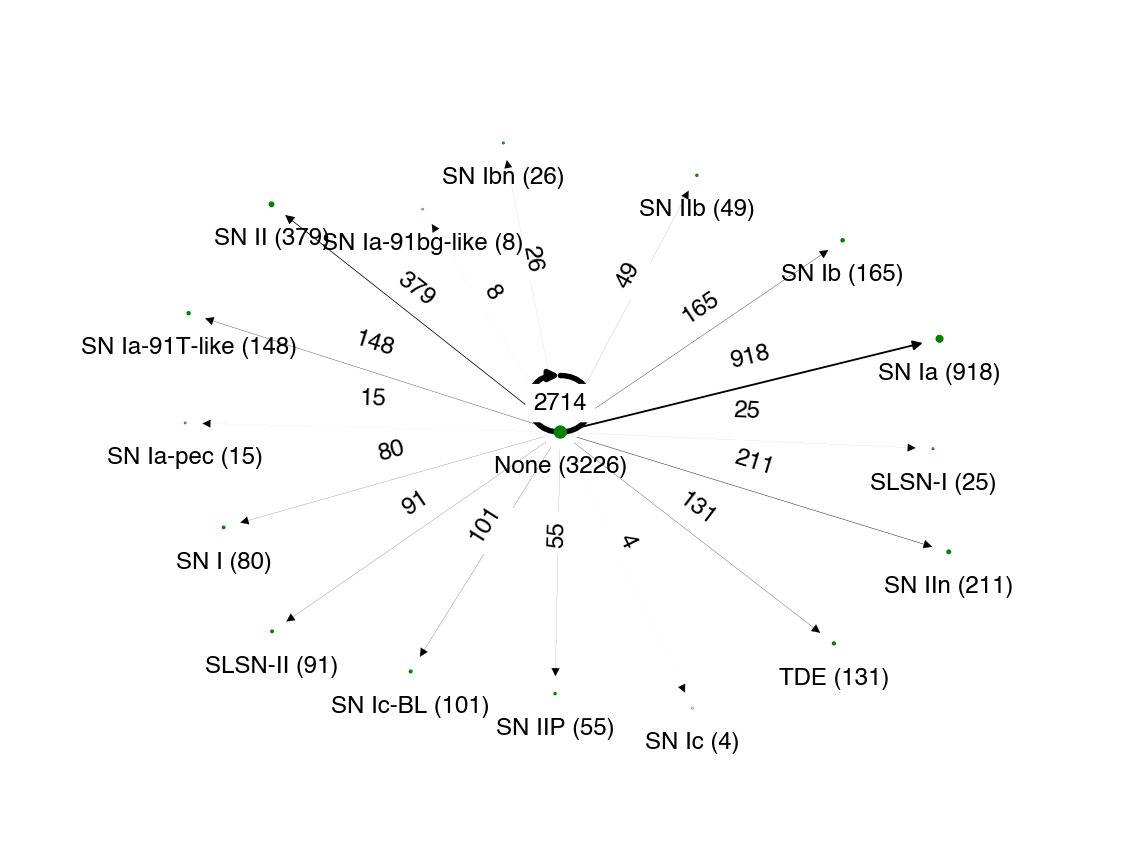

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


None


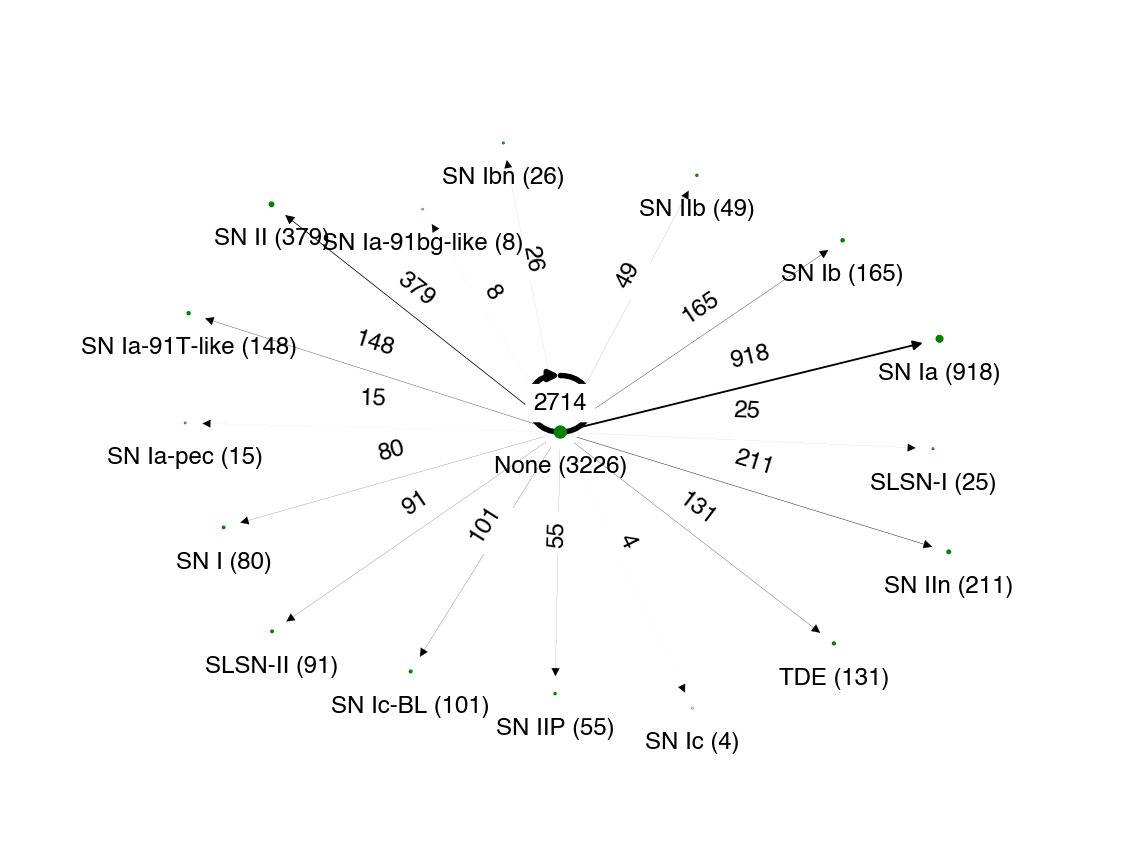

SLSN-I


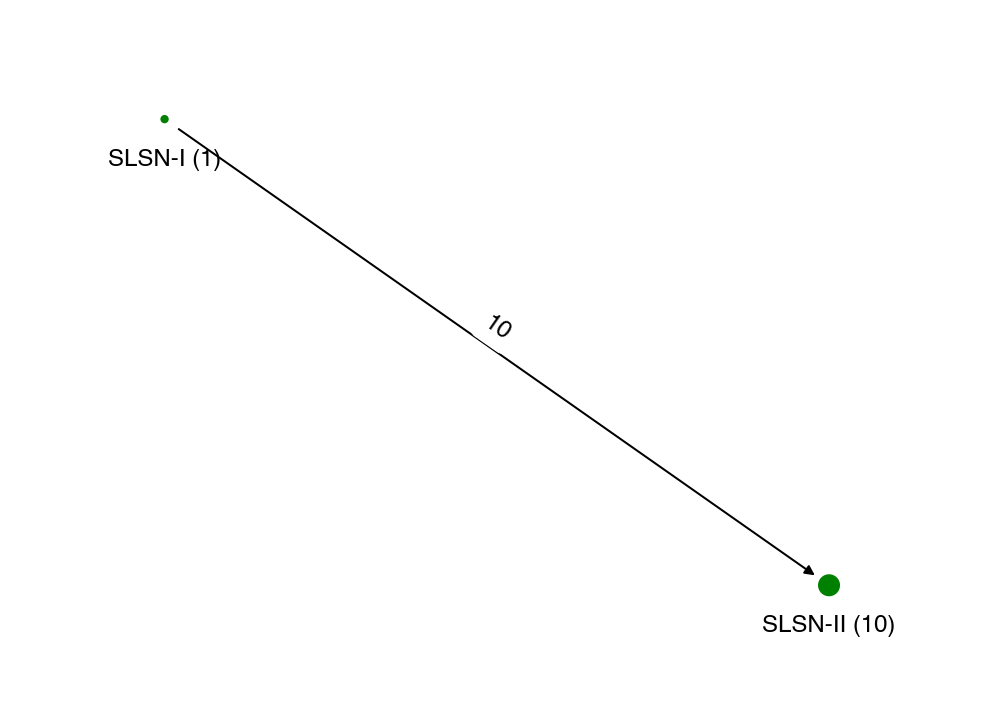

SLSN-II


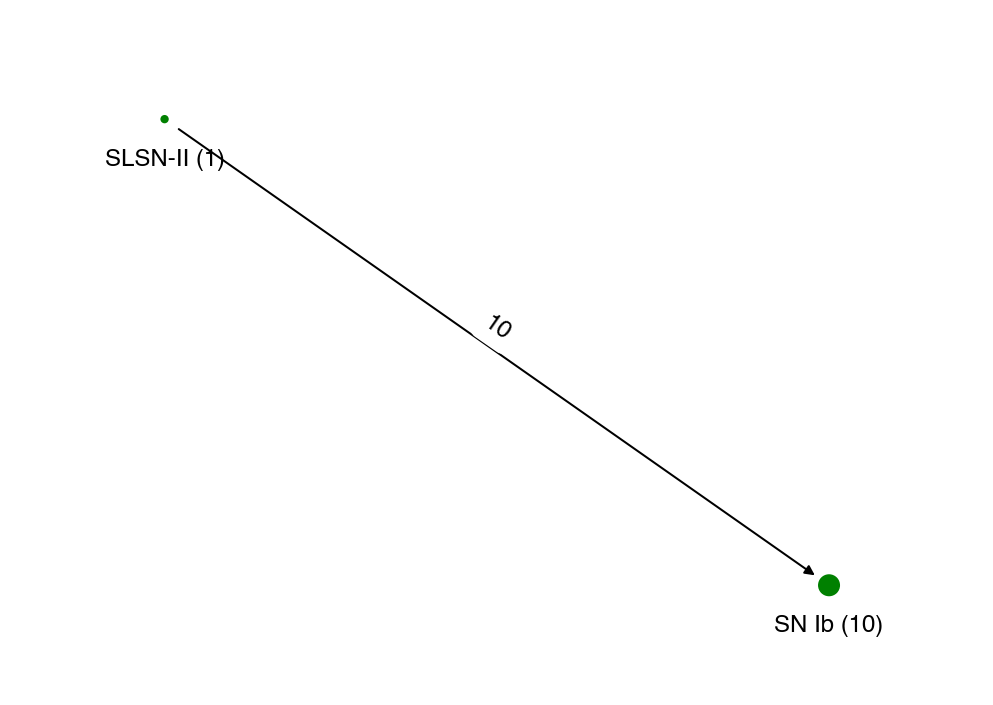

SN I


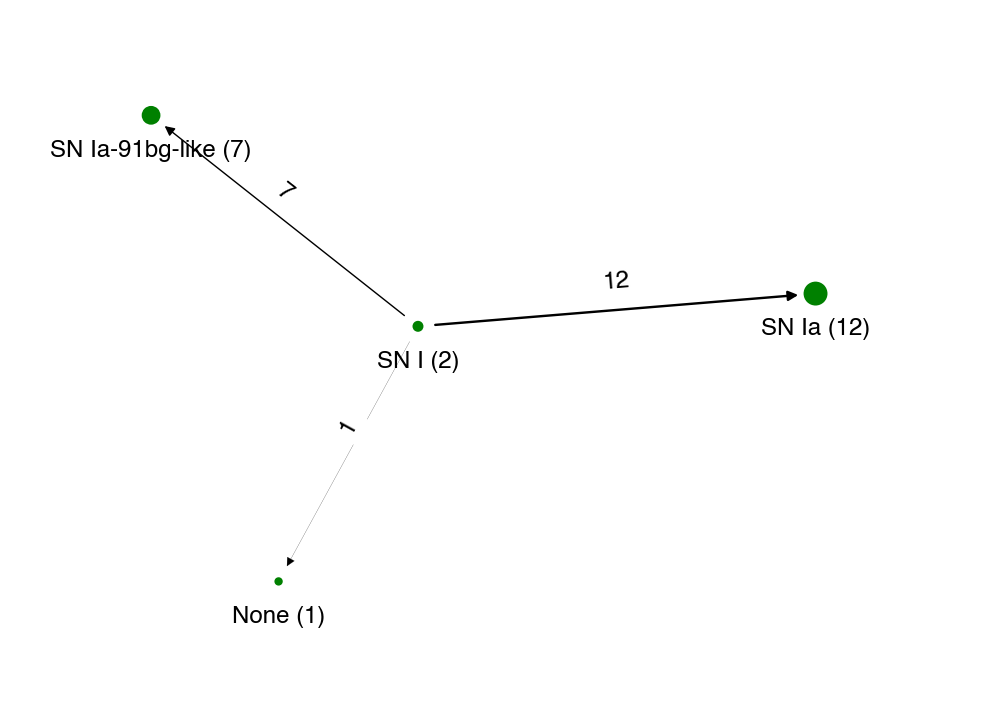

SN II


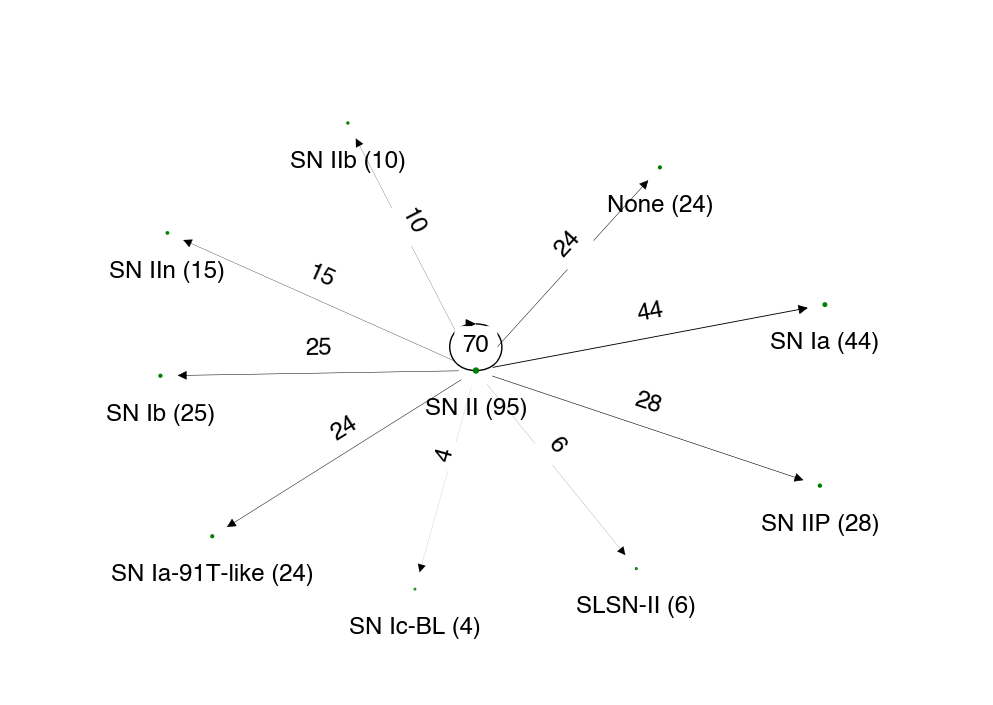

SN IIP


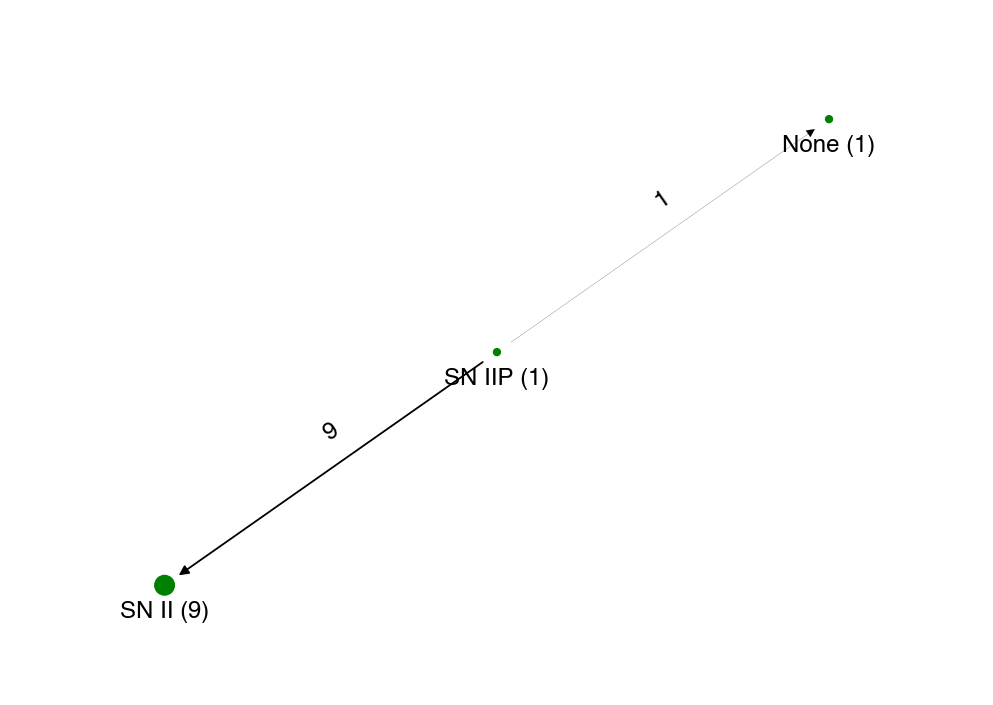

SN IIb


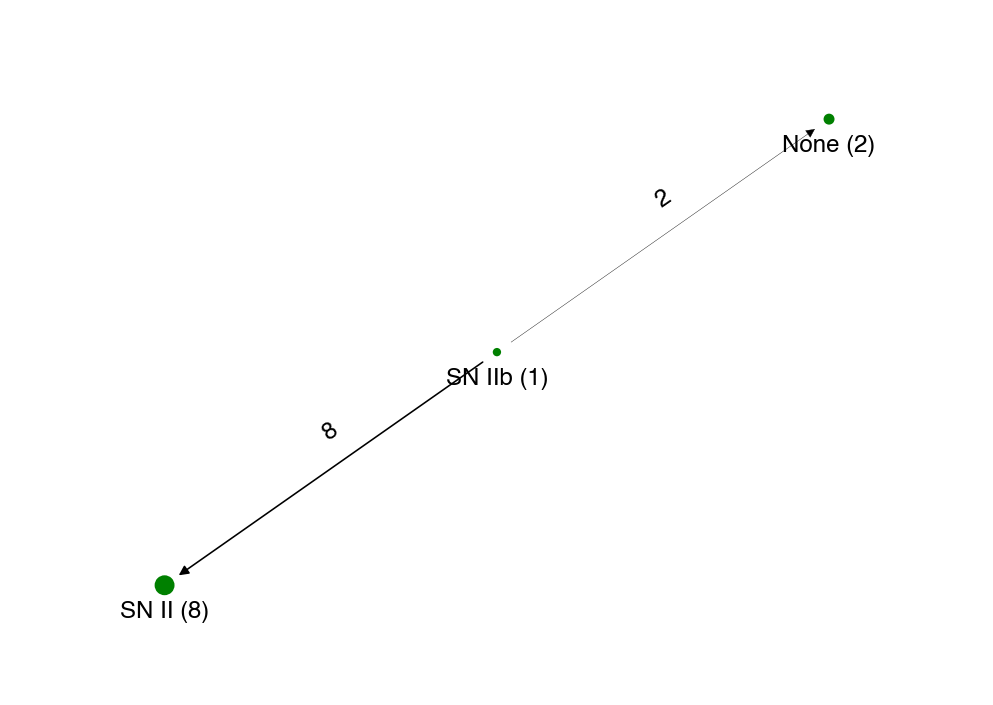

SN IIn


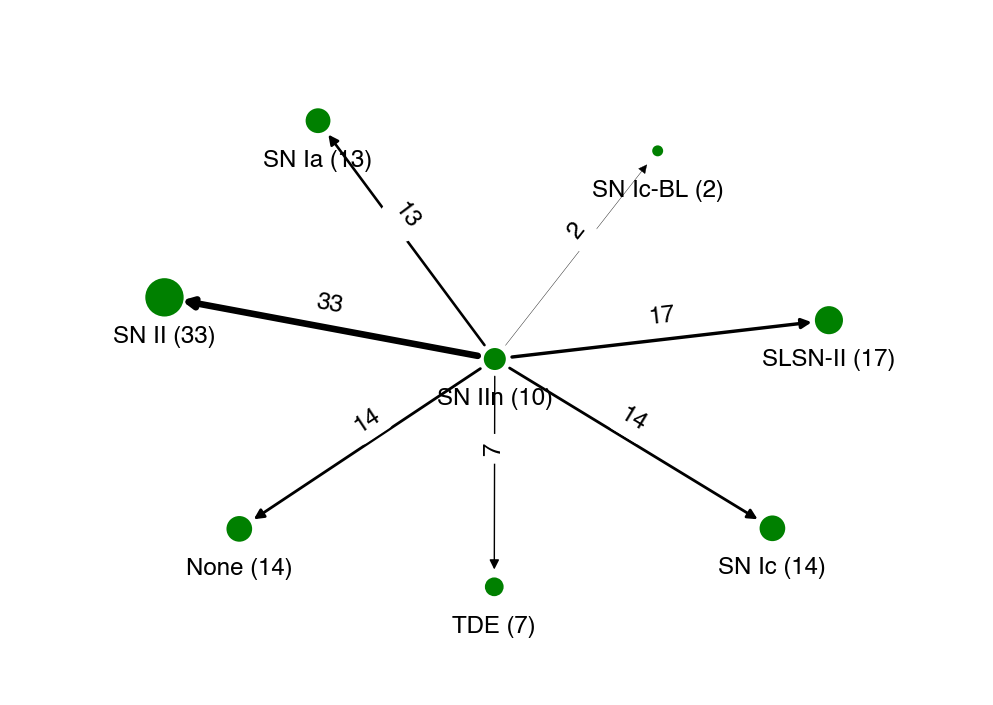

SN Ia


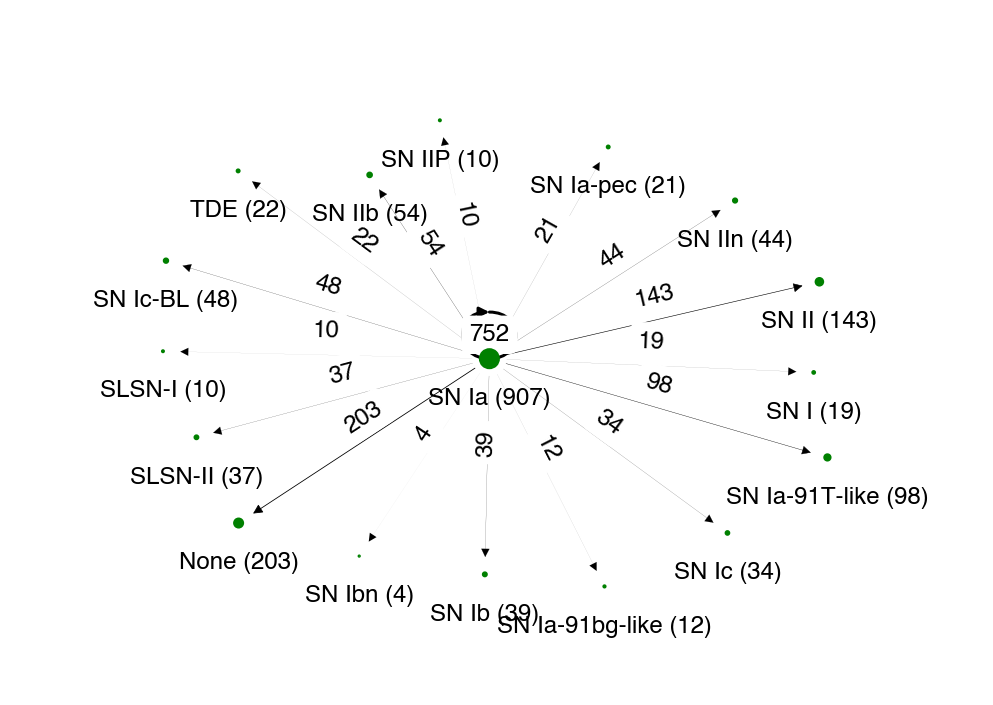

SN Ia-91T-like


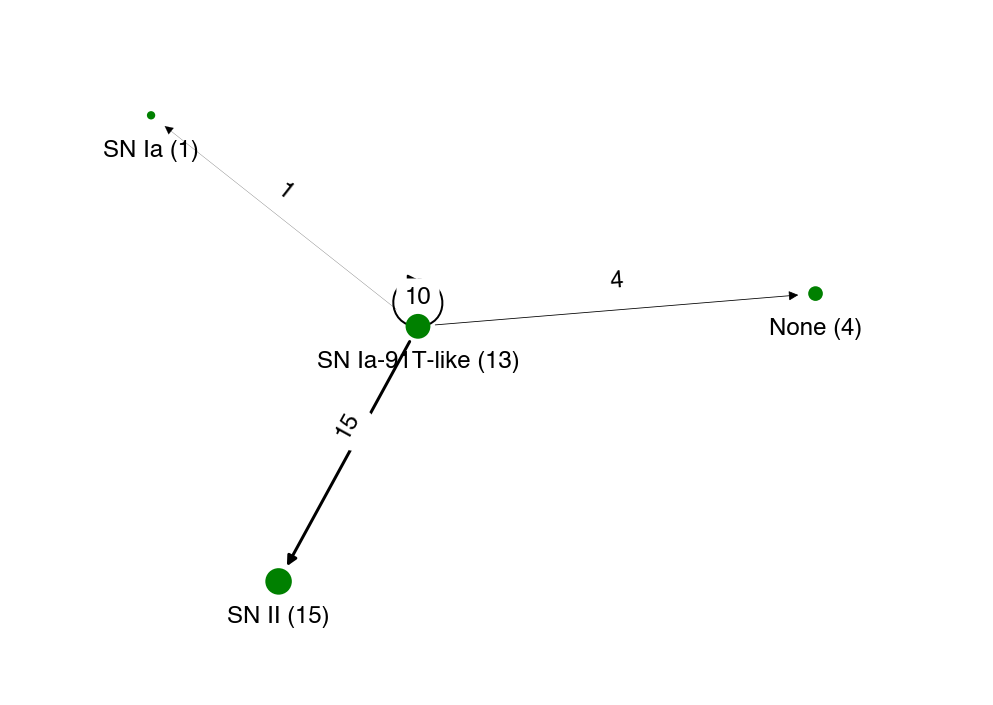

SN Ia-91bg-like


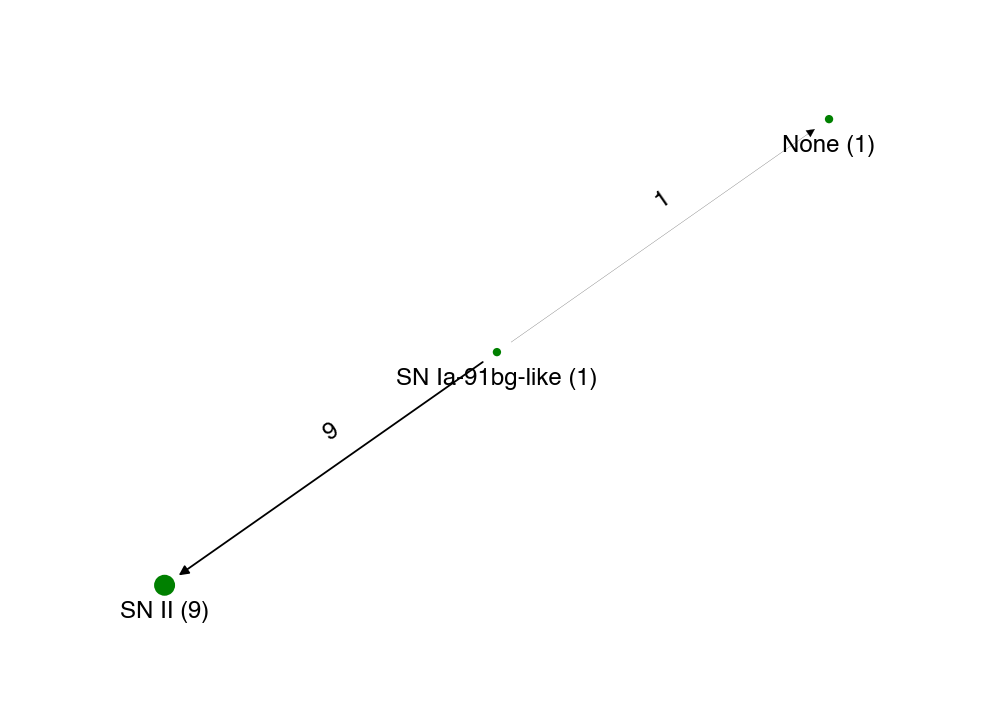

SN Ia-pec


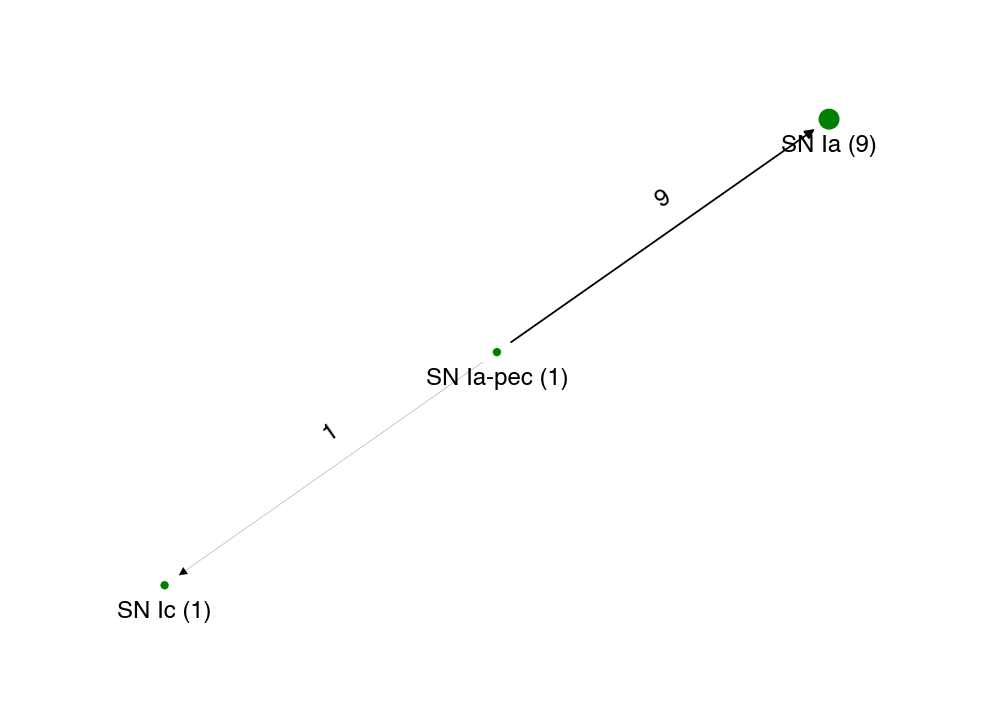

SN Ib


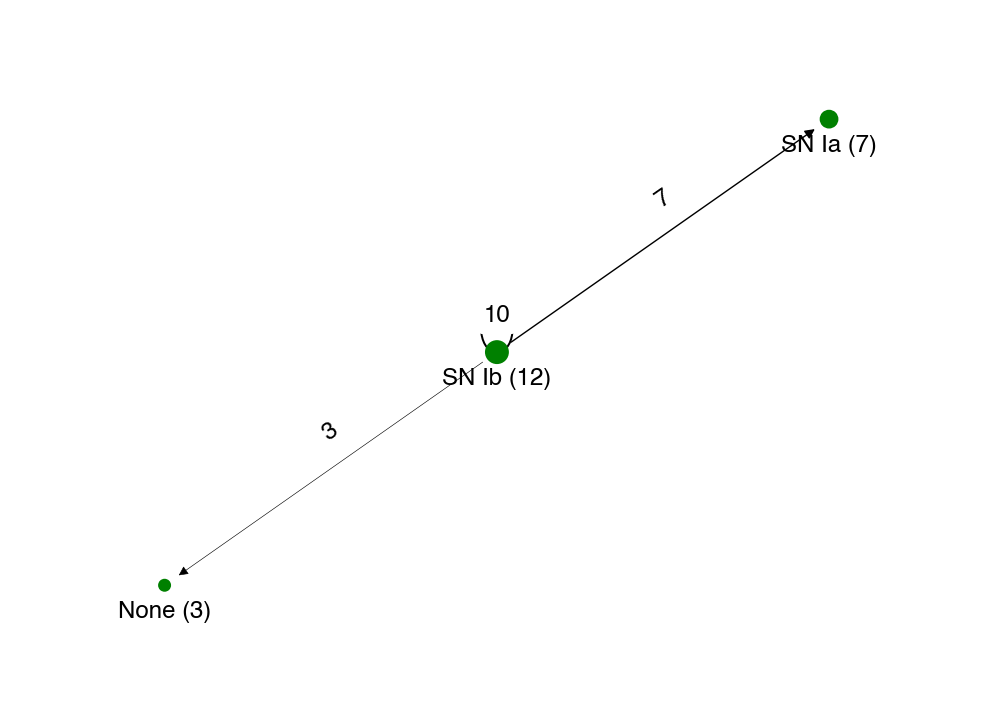

SN Ic


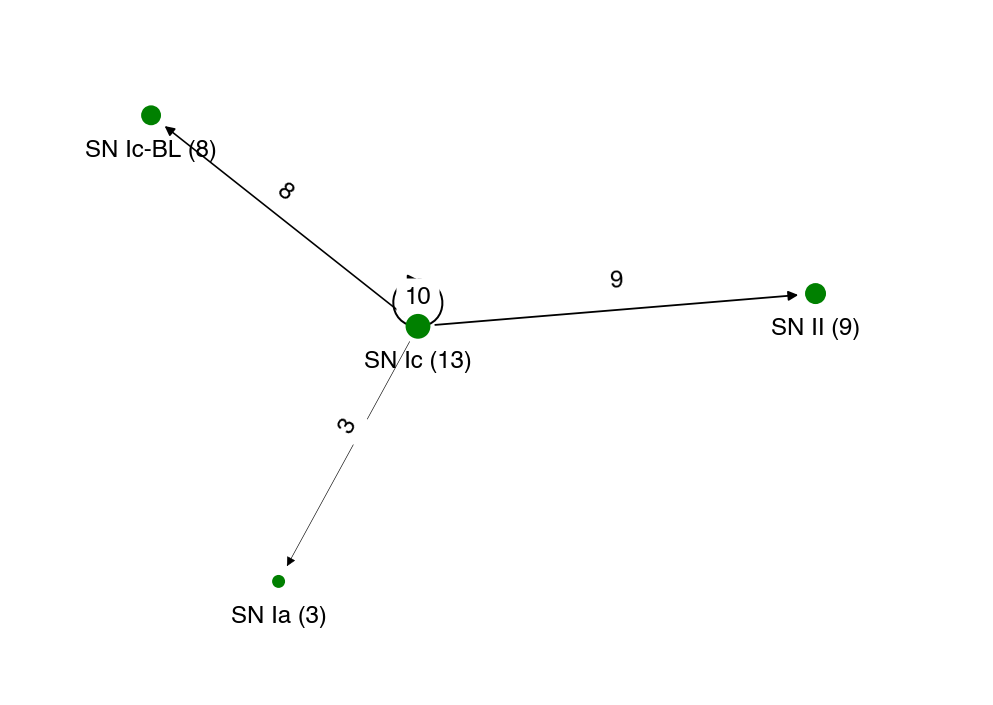

SN Ic-BL


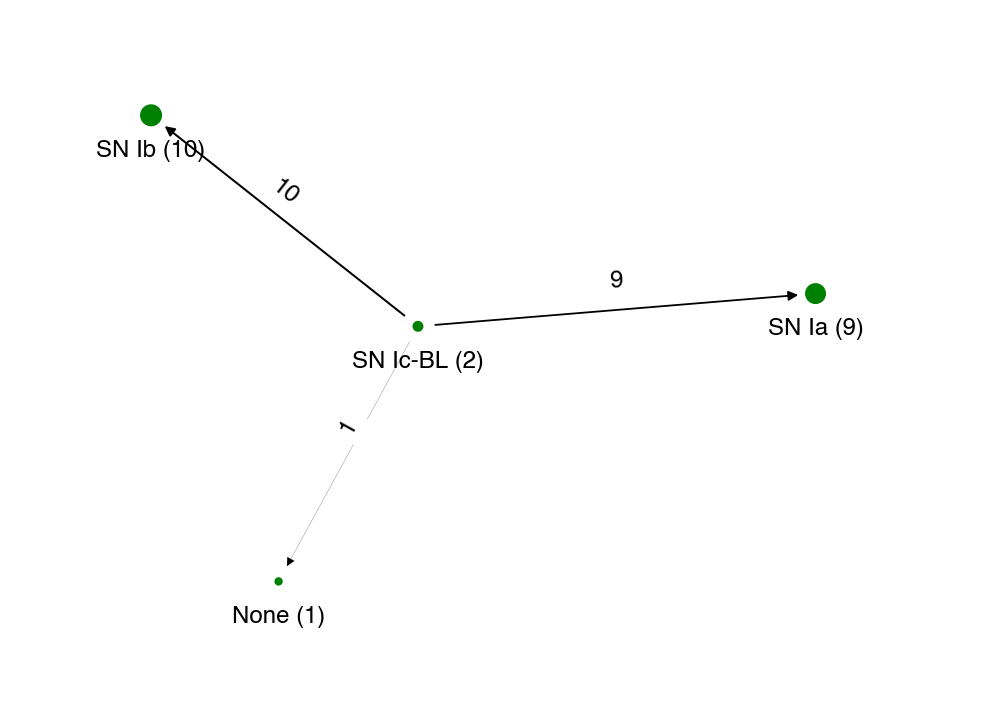

TDE


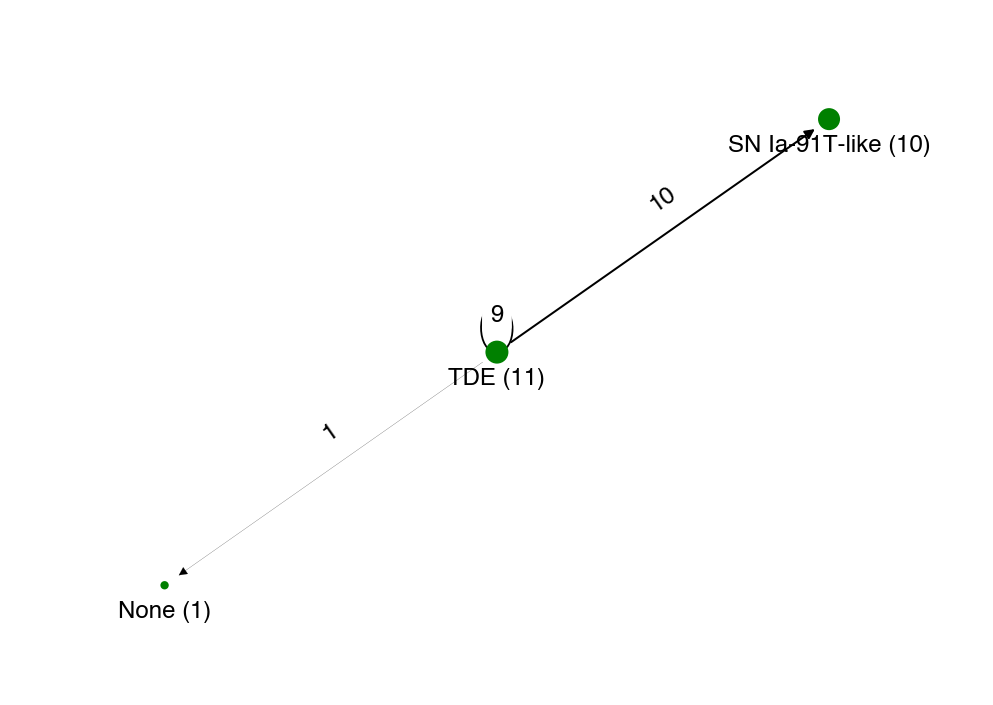

In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    
    folder_path = f"../figures/graphs/{suffix}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    plt.savefig(f'../figures/graphs/{suffix}/size_scaled_{cls}.jpg', dpi=300)
    plt.show()


In [35]:
Counter(full_ann_tns_cls_df['ann=0_tns_cls'])

Counter({'None': 512,
         'SN Ia': 155,
         'SN II': 25,
         'SN Ic-BL': 2,
         'SN IIn': 10,
         'SN Ic': 3,
         'SN I': 2,
         'TDE': 2,
         'SN IIb': 1,
         'SLSN-II': 1,
         'SLSN-I': 1,
         'SN Ia-91T-like': 3,
         'SN Ib': 2,
         'SN Ia-91bg-like': 1,
         'SN IIP': 1,
         'SN Ia-pec': 1})

In [ ]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-91T-like']

In [ ]:
full_ann_properties_df.loc['ZTF20achuvhd']

In [ ]:
full_ann_properties_df.loc['ZTF21aagnvvk']